# Data Collection

### Building Main Item List

In [ ]:
from src.utils import build_item_list
import os

current_dir = os.getcwd()
build_item_list(os.path.join(current_dir, 'src', 'data'))

Note: Due to differences in the way each item is displayed on the Steam Marketplace, Selenium struggles to find the hero name. This is especially true for hero items that belong to bundles!

### Getting Price History Data

In [1]:
from src.utils import process_price_history_row
import pandas as pd
import os

current_dir = os.getcwd()
df = pd.read_csv(os.path.join(current_dir, 'src', 'data', 'main.csv'))
df = df.drop(df[df['Hero ID'] == 0].index)

dir_path = os.path.join(current_dir, 'src', 'data', 'items')
df['Data Available'] = df.apply(lambda row: process_price_history_row(row, dir_path), axis=1)
df = df.drop(df[df['Data Available'] == False].index)
df.to_csv(os.path.join(current_dir, 'src', 'data', 'main.csv'), index = False)

Error: could not save price history for Taunt: The Cat Dancer!


This creates a useable subset of data by grabbing price history from the internal Steam Web API.

### Getting Hero Data

Due to a limit on the use of the API, this analysis only considers a single item. However, in the future, I would like to collect a much larger dataset, for higher frequency trading.  

Since I only get to choose one item here, I went with one of my favourite hero's item: Golden Dread Requisition.

It belongs to Lifestealer (Hero ID: 54) and came out August 31, 2020 from the gathered market data.

In [2]:
from src.utils import get_hero_stats

hero_id = 54
till_date = "2020-08-31"
with open('config.txt', 'r') as file:
    token = file.read().split('\n')[1]

results = get_hero_stats(hero_id, till_date, token)


In [9]:
import pandas as pd
import os

df = pd.DataFrame(results)
df['winPercentage'] = (df['winCount'] / df['matchCount']) * 100

# Take a peak
df.head(5)

# Save as CSV
current_dir = os.getcwd()
df.to_csv(os.path.join(current_dir, 'src', 'data', 'heros', '54.csv'), index = False)

Unfortunately, STRATZ API only keeps a store of monthly data going back years. For daily data, it only stores the past 12 days. Due to the low frequency nature of this strategy, it is important to use the longer timescale.

# The Strategy

The strategy essentially hinges on hero winrate impacting the popularity of the hero. The popularity of the hero increases the demand for items that belong to the hero, and with a limited supply, the price goes up.

While the asset is not consumed, it functions quite like a commodity - having the price be a function of supply and demand, and not on intrinsic valuation. These items also are quite illiquid due to limited volume, resembling some commodities that have limited volumes due to the natural process of obtaining them.

### Linear Regression

#### Data Manipulation

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

# Read Item CSV file
df_item = pd.read_csv(r"src\data\items\Golden%20Dread%20Requisition.csv")
df_item['Timestamp'] = pd.to_datetime(df_item['Timestamp'])
df_item.set_index('Timestamp', inplace=True)
df_item = df_item.resample('MS').mean()
display(df_item.head(5))

# Read Hero CSV file
df_hero = pd.read_csv(r"src\data\heros\54.csv")
df_hero['Timestamp'] = pd.to_datetime(df_hero['month'])
df_hero = df_hero[['Timestamp', 'winPercentage']]
df_hero.set_index('Timestamp', inplace=True)
display(df_hero.head(5))

# Merge both DFs
df = pd.merge(df_item, df_hero, left_index=True, right_index=True, how='inner')
df.head(5)

,Price,Volume
Timestamp,,
2020-09-01,0.264667,2852.100000
2020-10-01,0.243516,1105.193548
2020-11-01,0.256833,1226.333333
2020-12-01,0.205419,1013.032258
2021-01-01,0.174871,748.354839


,winPercentage
Timestamp,
2024-09-01,49.387486
2024-08-01,50.020162
2024-07-01,49.730506
2024-06-01,52.154103
2024-05-01,52.422699


,Price,Volume,winPercentage
Timestamp,,,
2020-09-01,0.264667,2852.100000,49.187262
2020-10-01,0.243516,1105.193548,49.078864
2020-11-01,0.256833,1226.333333,49.266379
2020-12-01,0.205419,1013.032258,47.534749
2021-01-01,0.174871,748.354839,47.950028


#### Exploratory Plots

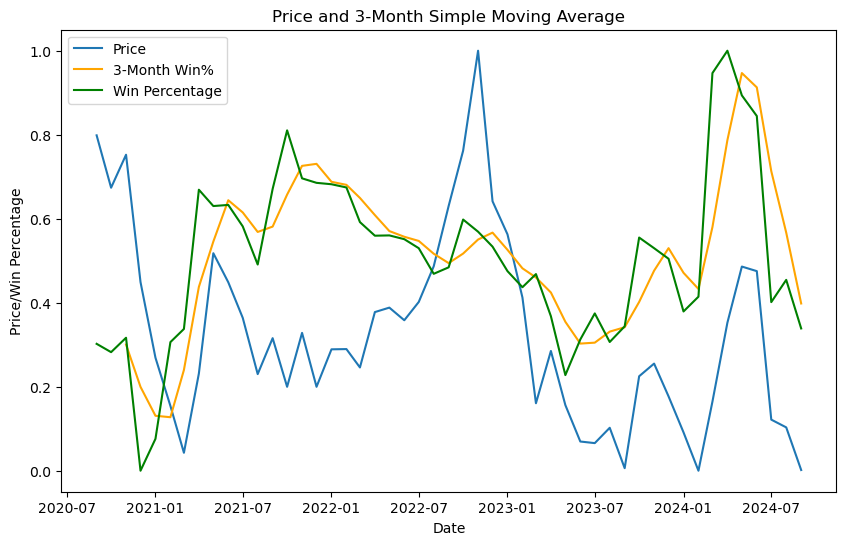

In [54]:
from sklearn.preprocessing import MinMaxScaler

# Assuming df_merged is your final DataFrame
scaler = MinMaxScaler()

# Normalize all columns
df_temp = pd.DataFrame(scaler.fit_transform(df), 
                             columns=df.columns, 
                             index=df.index)

# Calculate the 3-month Simple Moving Average (SMA)
df_temp['winPercentage_SMA'] = df_temp['winPercentage'].rolling(window=3).mean()

# Plot the original 'Price' data and the 10-day SMA
plt.figure(figsize=(10, 6))
plt.plot(df_temp['Price'], label='Price')
plt.plot(df_temp['winPercentage_SMA'], label='3-Month Win%', color='orange')
plt.plot(df_temp['winPercentage'], label='Win Percentage', color='green')
plt.title("Price and 3-Month Simple Moving Average")
plt.xlabel('Date')
plt.ylabel('Price/Win Percentage')
plt.legend()
plt.show()

In [55]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Create lagged columns for winPercentage
df['winPercentage_t-1'] = df['winPercentage'].shift(1)
df['winPercentage_t-2'] = df['winPercentage'].shift(2)
df['winPercentage_t-3'] = df['winPercentage'].shift(3)

# Drop rows with NaN values (due to shifting)
df.dropna(inplace=True)

# Define independent variables (including lagged features)
X = df[['winPercentage', 'winPercentage_t-1', 'winPercentage_t-2', 'winPercentage_t-3']]
y = df['Price']  # Dependent variable

# Create a LinearRegression model
model = LinearRegression()

# Fit the model
model.fit(X, y)

# Predict the Price values based on the variables
y_pred = model.predict(X)

# Calculate R-squared
r_squared = model.score(X, y)

# Print the R-squared value
print(f"R-squared: {r_squared}")

# Display the coefficient and intercept
print(f"Intercept: {model.intercept_}")
print(f"Coefficients: {model.coef_[0]} for winPercentage")
print(f"Coefficients: {model.coef_[1]} for winPercentage at t-1")
print(f"Coefficients: {model.coef_[2]} for winPercentage at t-2")
print(f"Coefficients: {model.coef_[3]} for winPercentage at t-3")

R-squared: 0.1397076339795168
Intercept: -0.27313672115701604
Coefficients: 0.0007246953206051288 for winPercentage
Coefficients: 0.01011754315626837 for winPercentage at t-1
Coefficients: 0.004660808461903859 for winPercentage at t-2
Coefficients: -0.006501958767861644 for winPercentage at t-3


Even though the R-squared is low, it still means that the feature has some potential for use as an explanatory variable. Ofcourse, the win percentage of the hero does not explain all of the variance in price, however this is a good start!

### Modelling Strategy

We can use a Gradient Boosted model to capture the

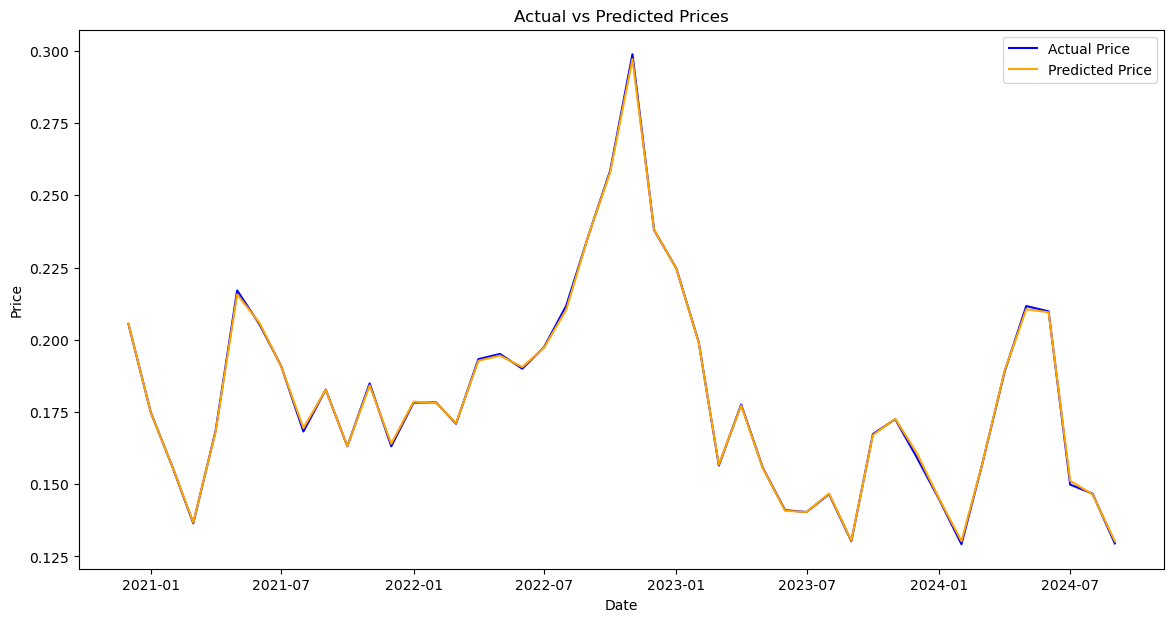

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

# Read Item CSV file
df_item = pd.read_csv(r"src\data\items\Golden%20Dread%20Requisition.csv")
df_item['Timestamp'] = pd.to_datetime(df_item['Timestamp'])
df_item.set_index('Timestamp', inplace=True)
df_item = df_item.resample('MS').mean()

# Read Hero CSV file
df_hero = pd.read_csv(r"src\data\heros\54.csv")
df_hero['Timestamp'] = pd.to_datetime(df_hero['month'])
df_hero = df_hero[['Timestamp', 'winPercentage']]
df_hero.set_index('Timestamp', inplace=True)

# Merge both DFs
df = pd.merge(df_item, df_hero, left_index=True, right_index=True, how='inner')

# Create lagged columns for winPercentage and Price
df['winPercentage_t-1'] = df['winPercentage'].shift(1)
df['winPercentage_t-2'] = df['winPercentage'].shift(2)
df['winPercentage_t-3'] = df['winPercentage'].shift(3)
df['Price_t-1'] = df['Price'].shift(1)
df['Price_t-2'] = df['Price'].shift(2)
df['Price_t-3'] = df['Price'].shift(3)

# Drop rows with NaN values
df.dropna(inplace=True)

# Define independent variables (including lagged features)
X = df[['winPercentage_t-1', 'winPercentage_t-2', 'winPercentage_t-3', 
         'Price_t-1', 'Price_t-2', 'Price_t-3']]
y = df['Price']  # Dependent variable

# Create an XGBoost regression model
model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
model.fit(X, y)

# Predict the Price values based on the features and Plot
predicted_prices = model.predict(X)
df['Predicted_Price'] = predicted_prices

plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Price'], label='Actual Price', color='blue')
plt.plot(df.index, df['Predicted_Price'], label='Predicted Price', color='orange')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [102]:
from backtesting import Backtest, Strategy

df['Open'] = df['Price']
df['High'] = df['Price']
df['Low'] = df['Price']
df['Close'] = df['Price']

# Create a class for trading strategy
class RegressionStrategy(Strategy):
    def init(self):
        self.model = model  # Use the fitted model

    def next(self):
        # Access the last few values using self.data
        if len(self.data) < 3:  # Ensure there are enough data points
            return
        
        # Use the last three entries for prediction
        win_percentage_t_1 = self.data['winPercentage'][-1]
        win_percentage_t_2 = self.data['winPercentage'][-2]
        win_percentage_t_3 = self.data['winPercentage'][-3]
        price_t_1 = self.data['Price'][-1]
        price_t_2 = self.data['Price'][-2]
        price_t_3 = self.data['Price'][-3]

        # Prepare input for the model
        X_new = [[win_percentage_t_1, win_percentage_t_2, win_percentage_t_3,
                   price_t_1, price_t_2, price_t_3]]
        
        # Predict the price using the model
        predicted_price = self.model.predict(X_new)[0]

        # Get the current price
        current_price = self.data['Price'][-1]

        # For Debugging
        # print(f'At {self.data.index[-1]}, Position = {self.position}, Predicted = {predicted_price} vs current = {current_price}')

        # Buy condition
        if predicted_price > current_price * 1.01:
            self.buy()

        # Sell condition
        elif predicted_price < current_price * 0.99:
            self.position.close()

# Create and run the backtest
bt = Backtest(df, RegressionStrategy, cash=10000, commission=.002)
stats = bt.run()
print(stats)

# Plotting the results
bt.plot()


Start                     2020-12-01 00:00:00
End                       2024-09-01 00:00:00
Duration                   1370 days 00:00:00
Exposure Time [%]                   65.217391
Equity Final [$]                 10565.207729
Equity Peak [$]                  13532.558523
Return [%]                           5.652077
Buy & Hold Return [%]              -36.947102
Return (Ann.) [%]                   54.691717
Volatility (Ann.) [%]              501.816232
Sharpe Ratio                         0.108988
Sortino Ratio                        0.590711
Calmar Ratio                         1.320797
Max. Drawdown [%]                  -41.408117
Avg. Drawdown [%]                  -24.031555
Max. Drawdown Duration      670 days 00:00:00
Avg. Drawdown Duration      427 days 00:00:00
# Trades                                   10
Win Rate [%]                             30.0
Best Trade [%]                      33.248145
Worst Trade [%]                    -12.482504
Avg. Trade [%]                    

GridPlot(id='p16201', ...)

# Result Discussions

While the results are in-sample, and to be completely certain (i.e. if I was deploying this strategy) it is of the utmost importance that we see the model's out of sample performance, the in-sample results still paint a interesting picture. 

While the asset itself has lost value, the trading strategy seems to do much better compared to the buy-and-hold (+5% vs -37%). This could be a good defensive strategy in cases of bear markets in the Steam Marketplace world.  

With regards to an out-of-sample test for robustness, the extremely limited amount of data handicaps the project, as it is difficult to do find much historical data of hero winrates and popularity, unless storing data as a part of this trading project.

For further work, lots of interesting alternate data can be included. It is likely that heroes that are featured more in Dota 2 tournaments also see their popularity increase! Other ideas include the timing of Steam sales (as supply increases due to player's seeking liquidity to buy games inside the Steam sphere), seasonality of player numbers, etc.